In [1]:
## Triplet's rate equation solving

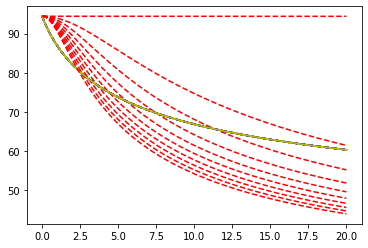

In [4]:
import numpy as np
import matplotlib.pyplot as plt

k_isc = 1E-3        # 1/ns
tau_s = 98          # ns
k_risc = 2.2*1E-4   # 1/ns
tau_t = 100E+3      # ns
G = np.linspace(1E-12,20,200)
k_tta = 8*1E-9      # From literature (m^3/ns)

param_corr_arr = np.linspace(1E-17,1E-12,10) # Our parameter m^6/ns

def calculate_coefs(k_isc,tau_s,k_risc,tau_t,k_tta,param_corr):
    lambda_coef = (1+k_isc*tau_s)/k_isc
    
    
    #a_corrT^3 + 0*T^2 + b_corr*T + G*c_corr = 0
    #leo
    a_corr = (-1)*param_corr
    b_corr = (-1)*(1/tau_t) + (-1)*(k_risc) + (k_isc*k_risc)/((1/tau_s) + k_isc)
    c_corr = 0.75 + 0.25*k_isc/((1/tau_s) + k_isc)
    
    
    
    #a_convT^2 b_conv*T + G*c_conv = 0
    
    a_conv = 0.25*tau_s*k_tta*k_isc/(1+k_isc*tau_s) + (-1)*1.25*k_tta
    b_conv = (-1)*(1/tau_t) + (-1)*k_risc + (k_risc*k_isc*tau_s)/(1+k_isc*tau_s)
    c_conv = 0.75 + (0.25*k_isc*tau_s)/(1+k_isc*tau_s)    

    #p = (5*k_tta+4*k_tta*k_isc*tau_s)
    #a_conv = 1
    #b_conv = (4*(1/tau_t)+4*k_isc*tau_s*(1/tau_t)+4*k_risc)/p
    #c_conv = (-1)*(4*0.75+4*k_isc*tau_s)/p

    
    return a_corr,b_corr,c_corr,a_conv,b_conv,c_conv
    
def triplet_correction(g,a_corr,b_corr,c_corr): # root of a_corrT^3 + 0*T^2 + b_corr*T + G*c_corr = 0
    return np.roots([a_corr,0,b_corr,g*c_corr])

def triplet_convetional(g,a_conv,b_conv,c_conv): # root of a_convT^2 b_conv*T + G*c_conv = 0
    return np.roots([a_conv,b_conv,g*c_conv])
def article_expression(g): # the exact expression from the article (debug purposes)
    c1  = (5*k_tta + 4*k_tta*k_isc*tau_s)
    c2  = (1/tau_t + k_isc*tau_s/tau_t +k_risc)
    c3  = c2/c1
    c4  = (0.75*g + k_isc*tau_s*g)/c1
    #print(c1,c2,c3,c4)
    return -2*c3 + np.sqrt(4*c3*c3 + 4*c4)

def S_conv(T,g):
    return (0.25*tau_s*g + k_risc*tau_s*T + 0.25*k_tta*tau_s*T*T)/(1+k_isc*tau_s)
def S_corr(T,g):
    return (0.25*g*tau_s + k_risc*tau_s*T)/(1+k_isc*tau_s)

def dump_graphs(x,y,filename):
    n = len(x)
    with open(filename,'w') as f:
        for i in range(n):
            f.write('{} {}\n'.format(x[i],y[i]))
indx = 0
for param_corr in param_corr_arr:
    indx = indx+1
    tcorr      = [] # Triplet density for a given G
    tconv      = [] # Triplet density for a given G
    tarticle   = [] # Triplet density for a given G
    g_allowed  = [] # G values in which the polynomials' roots are real
    
    for g in G:

        a_corr,b_corr,c_corr,a_conv,b_conv,c_conv = calculate_coefs(k_isc,tau_s,k_risc,tau_t,k_tta,param_corr)

        sols_corr      = triplet_correction(g,a_corr,b_corr,c_corr)
        real_sols_corr = [x.real for x in sols_corr if x.imag == 0 and x.real >=0]

        sols_conv      = triplet_convetional(g,a_conv,b_conv,c_conv)
        real_sols_conv = [x.real for x in sols_conv if x.imag == 0 and x.real >=0]
        
        if real_sols_corr and real_sols_conv:
            if len(real_sols_corr) > 1 or len(real_sols_conv) > 1:
                print('duplicated sols')
            s_corr    = S_corr(real_sols_corr[0],g)
            s_conv    = S_conv(real_sols_conv[0],g)
            s_article = S_conv(article_expression(g),g)
            
            tcorr.append(s_corr/g)
            tconv.append(s_conv/g)
            tarticle.append(s_article/g)
            g_allowed.append(g)
    plt.ioff()
    
    
    #inline plot
    #fig1, ax1 = plt.subplots()
    #fig2, ax2 = plt.subplots()
    #ax1.plot(g_allowed,tconv,'--b',label='conventional')
    #ax2.plot(g_allowed,tcorr,'--r',label='corrected(%s)'%(param_corr))
    
    plt.plot(g_allowed,tconv,'--b',label='conventional')
    plt.plot(g_allowed,tarticle,'-y',label='article')
    plt.plot(g_allowed,tcorr,'--r',label='corrected(%s)'%(param_corr))
    
    #side-by-side plot (outside jupyter)
    #plt.legend()
    #plt.show()
#plt.legend()
plt.show()
